# Comparison of $P_\mathrm{out}$ to results by Gruber et al

Gruber et al. simulated wind power output using ERA5 data and applied a bias correction using GWA2. Wind speeds are converted to wind power using Ryberg's power curve model. The results are aggregated monthly and comparted to wind power output reported by the EIA. The RSME between monthly capacity factors in the period 2010 - 2019 was found to be **0.031**.

$P_\mathrm{out}$ is very similar, but aggregated yearly.

*References:*

Katharina Gruber et al. Towards global validation of wind power simulations: A multi-country assessment of wind power simulation from MERRA-2 and ERA-5 reanalyses bias-corrected with the Global Wind Atlas. In:Energy (2021), p. 121520.

In [1]:
from init import *

In [2]:
matplotlib.rc('figure', figsize=(15, 10))

In [3]:
p_out_model = load_p_out_model()
p_out_eia = load_p_out_eia()

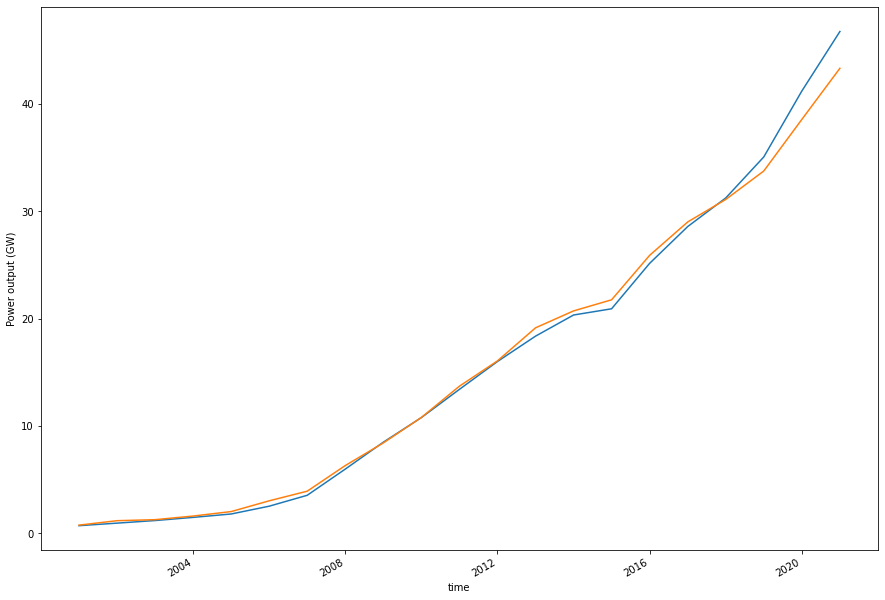

In [4]:
p_out_model.plot()
p_out_eia.plot()

In [5]:
turbines = load_turbines()

In [6]:
is_built = calc_is_built(turbines, p_out_model.time)

In [7]:
capacity = 1e-6 * (is_built * turbines.t_cap).sum(dim='turbines')

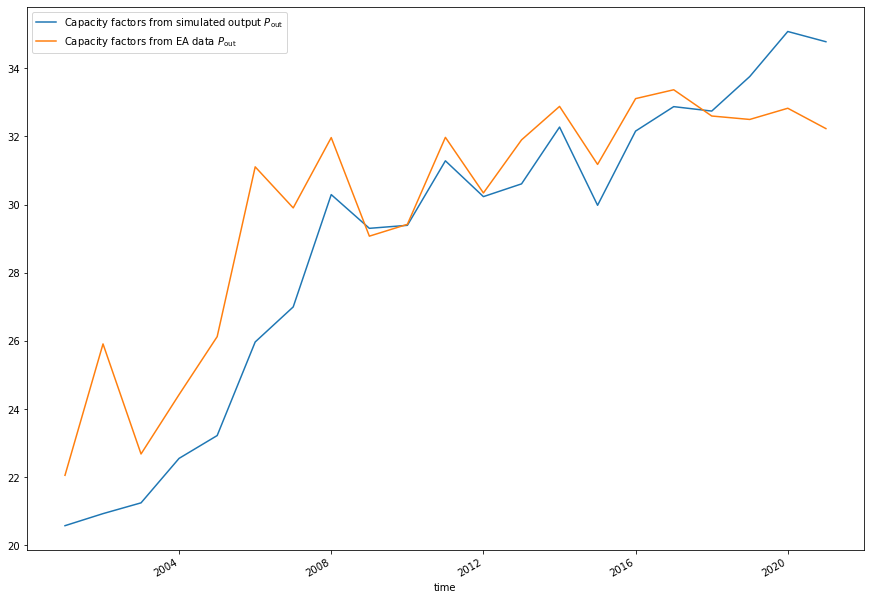

In [8]:
(100 * p_out_model / capacity).plot(label='Capacity factors from simulated output $P_\mathrm{out}$')
(100 * p_out_eia / capacity).plot(label='Capacity factors from EA data $P_\mathrm{out}$')
plt.legend();

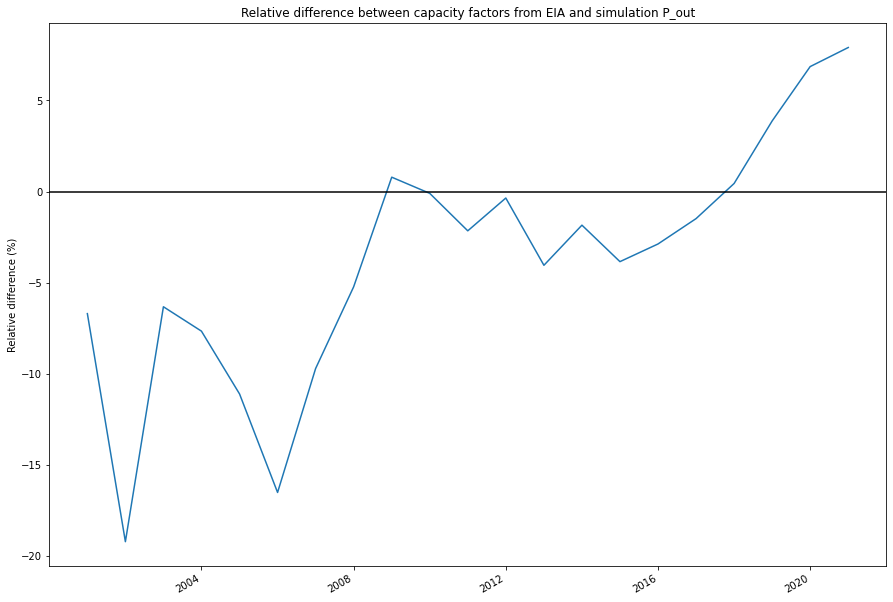

In [9]:
(100 * ((p_out_model / capacity) - (p_out_eia / capacity))/(p_out_eia / capacity)).plot()
plt.axhline(0, color='k')
plt.ylabel('Relative difference (%)')
plt.xlabel('')
plt.title('Relative difference between capacity factors from EIA and simulation P_out');


In [10]:
def filter(a):
    start_year = 2010
    end_year = 2019
    return a.sel(time=(start_year <= a.time.dt.year)  & (a.time.dt.year <= end_year))

In [11]:
def rmse(a, b, start_year, end_year):
    return ((a - b).sel(
        time=(start_year <= (a-b).time.dt.year) & ((a-b).time.dt.year <= end_year)
    )**2).sum(dim='time')**0.5

RMSE betweem capacity factors from simulation not including the loss factor and EIA from yearly time series between 2010 and 2019:

In [12]:
rmse(p_out_model / LOSS_CORRECTION_FACTOR / capacity, p_out_eia / capacity, 2010, 2019).load()

<xarray.DataArray ()>
array(0.11918866)

This is way more than the result by Gruber et al. On the other hand, if the loss factor *is* included, it's surprisingly close:

In [13]:
rmse(p_out_model / capacity, p_out_eia / capacity, 2010, 2019).load()

<xarray.DataArray ()>
array(0.02592253)

Unfortunately this is still more than the RMSE from the monthly result (and yearly aggregation can only decrease the RMSE).

This means that we were unable to reproduce the earlier results. Possible causes include:
 - different data cleaning process
 - different USWTDB versions
 - different data imputation for turbine meta data
 - a bug in one of the two computations